In [38]:
!wget https://ftp.cpc.ncep.noaa.gov/godas/pentad/2025/godas.P.20250105.grb

--2025-09-26 12:20:37--  https://ftp.cpc.ncep.noaa.gov/godas/pentad/2025/godas.P.20250105.grb
Resolving ftp.cpc.ncep.noaa.gov (ftp.cpc.ncep.noaa.gov)... 140.90.101.71
Connecting to ftp.cpc.ncep.noaa.gov (ftp.cpc.ncep.noaa.gov)|140.90.101.71|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41055658 (39M)
Saving to: ‘godas.P.20250105.grb.1’

godas.P.20250105.gr 100%[===================>]  39.15M  4.42MB/s    in 9.4s    

2025-09-26 12:20:47 (4.18 MB/s) - ‘godas.P.20250105.grb.1’ saved [41055658/41055658]



In [39]:
!ls

godas.P.20250105.grb  godas.P.20250105.grb.1  sample_data


In [40]:
!pip install cfgrib xarray

In [41]:
!pip install pygrib

In [42]:
import pygrib

# Open the GRIB file
grbs = pygrib.open('godas.P.20250105.grb')

# Print all available messages
for grb in grbs:
    print(grb)

# # Read a specific variable (e.g., temperature)
# temp = grbs.select(name='Temperature')[0]  # Adjust variable name as needed
# print(temp.values)  # To get the temperature values

1:Potential temperature:K (7):regular_ll:depthBelowSea:level 5:from 202501050000
2:Potential temperature:K (7):regular_ll:depthBelowSea:level 15:from 202501050000
3:Potential temperature:K (7):regular_ll:depthBelowSea:level 25:from 202501050000
4:Potential temperature:K (7):regular_ll:depthBelowSea:level 35:from 202501050000
5:Potential temperature:K (7):regular_ll:depthBelowSea:level 45:from 202501050000
6:Potential temperature:K (7):regular_ll:depthBelowSea:level 55:from 202501050000
7:Potential temperature:K (7):regular_ll:depthBelowSea:level 65:from 202501050000
8:Potential temperature:K (7):regular_ll:depthBelowSea:level 75:from 202501050000
9:Potential temperature:K (7):regular_ll:depthBelowSea:level 85:from 202501050000
10:Potential temperature:K (7):regular_ll:depthBelowSea:level 95:from 202501050000
11:Potential temperature:K (7):regular_ll:depthBelowSea:level 105:from 202501050000
12:Potential temperature:K (7):regular_ll:depthBelowSea:level 115:from 202501050000
13:Potential

In [43]:
import pygrib
import xarray as xr
import numpy as np
from datetime import datetime

# Open the GRIB file with pygrib
file_name = 'godas.P.20250105.grb'
grbs = pygrib.open(file_name)

# Initialize lists to store DataArrays for temperature and salinity
temperature_da_list = []
salinity_da_list = []

# Loop through all levels for Potential Temperature and Salinity
for grb in grbs:
    if 'Potential temperature' in grb.name:
        # Extract data and metadata for Potential Temperature
        data = grb.values
        lats, lons = grb.latlons()

        # Create coordinates (latitude, longitude)
        coords = {
            'latitude': (['lat'], lats[:, 0]),
            'longitude': (['lon'], lons[0, :]),
        }

        # Create a DataArray for Potential Temperature
        temp_da = xr.DataArray(data, coords=coords, dims=['lat', 'lon'])

        # Append the DataArray to the list
        temperature_da_list.append(temp_da)

    elif 'Salinity' in grb.name:
        # Extract data and metadata for Salinity
        data = grb.values
        lats, lons = grb.latlons()

        # Create coordinates (latitude, longitude)
        coords = {
            'latitude': (['lat'], lats[:, 0]),
            'longitude': (['lon'], lons[0, :]),
        }

        # Create a DataArray for Salinity
        salinity_da = xr.DataArray(data, coords=coords, dims=['lat', 'lon'])

        # Append the DataArray to the list
        salinity_da_list.append(salinity_da)

# Combine the DataArrays into a single xarray Dataset
# Stack the DataArrays for temperature and salinity along a new 'level' dimension
ds = xr.Dataset({
    'potential_temperature': (['time', 'level', 'lat', 'lon'], np.stack(temperature_da_list)[np.newaxis]),
    'salinity': (['time', 'level', 'lat', 'lon'], np.stack(salinity_da_list)[np.newaxis])
})
date_str = file_name.split('.')[2]  # Extract the date part from the filename
time = datetime.strptime(date_str, "%Y%m%d")  # Convert the date string to datetime


# Add a 'level' coordinate
ds['level'] = np.arange(1, len(temperature_da_list) + 1)  # Adjust based on your dataset
ds['lat'] = lats[:,0]
ds['lon'] = lons[0,:]
# Add the time as a coordinate (without overwriting the time dimension)
ds.coords['time'] = [time]  # Assign the same time for all records as extracted from the filename

# Inspect the dataset
print(ds)
ds.to_netcdf(file_name[:-3]+'nc')

<xarray.Dataset> Size: 96MB
Dimensions:                (time: 1, level: 40, lat: 418, lon: 360)
Coordinates:
  * level                  (level) int64 320B 1 2 3 4 5 6 ... 35 36 37 38 39 40
  * lat                    (lat) float64 3kB -74.5 -74.17 -73.83 ... 64.03 64.5
  * lon                    (lon) float64 3kB 0.5 1.5 2.5 ... 357.5 358.5 359.5
  * time                   (time) datetime64[ns] 8B 2025-01-05
Data variables:
    potential_temperature  (time, level, lat, lon) float64 48MB nan nan ... nan
    salinity               (time, level, lat, lon) float64 48MB nan nan ... nan


In [44]:
file_name[:-3]+'nc'

'godas.P.20250105.nc'

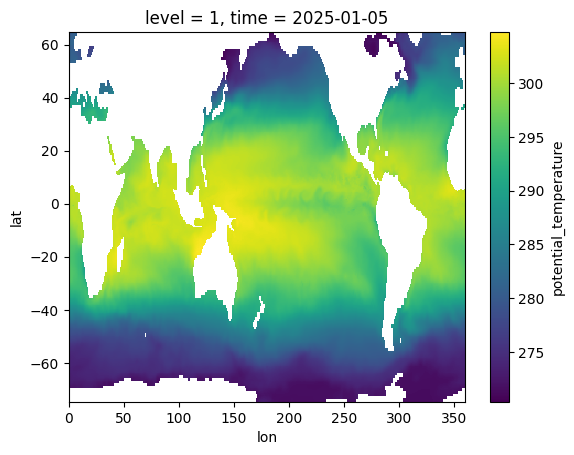

In [45]:
ds.isel(level=0).potential_temperature.plot()

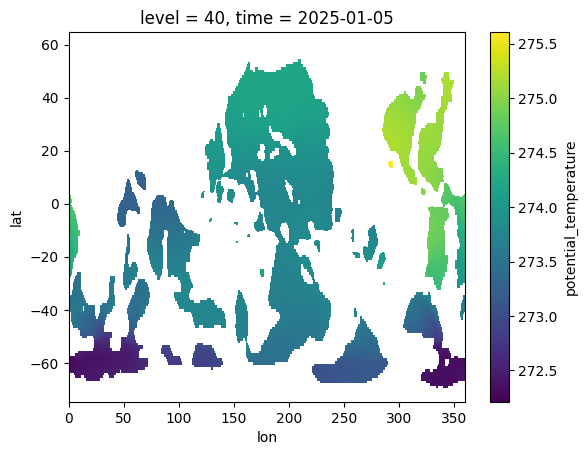

In [46]:
ds.isel(level=39).potential_temperature.plot()

In [47]:
lats[:,0]

array([-74.5  , -74.167, -73.834, -73.501, -73.168, -72.835, -72.502,
       -72.169, -71.836, -71.503, -71.17 , -70.837, -70.504, -70.171,
       -69.838, -69.505, -69.172, -68.839, -68.506, -68.173, -67.84 ,
       -67.507, -67.174, -66.841, -66.508, -66.175, -65.842, -65.509,
       -65.176, -64.843, -64.51 , -64.177, -63.844, -63.511, -63.178,
       -62.845, -62.512, -62.179, -61.846, -61.513, -61.18 , -60.847,
       -60.514, -60.181, -59.848, -59.515, -59.182, -58.849, -58.516,
       -58.183, -57.85 , -57.517, -57.184, -56.851, -56.518, -56.185,
       -55.852, -55.519, -55.186, -54.853, -54.52 , -54.187, -53.854,
       -53.521, -53.188, -52.855, -52.522, -52.189, -51.856, -51.523,
       -51.19 , -50.857, -50.524, -50.191, -49.858, -49.525, -49.192,
       -48.859, -48.526, -48.193, -47.86 , -47.527, -47.194, -46.861,
       -46.528, -46.195, -45.862, -45.529, -45.196, -44.863, -44.53 ,
       -44.197, -43.864, -43.531, -43.198, -42.865, -42.532, -42.199,
       -41.866, -41.

In [48]:
lons[0,:]

array([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
         9.5,  10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,  17.5,
        18.5,  19.5,  20.5,  21.5,  22.5,  23.5,  24.5,  25.5,  26.5,
        27.5,  28.5,  29.5,  30.5,  31.5,  32.5,  33.5,  34.5,  35.5,
        36.5,  37.5,  38.5,  39.5,  40.5,  41.5,  42.5,  43.5,  44.5,
        45.5,  46.5,  47.5,  48.5,  49.5,  50.5,  51.5,  52.5,  53.5,
        54.5,  55.5,  56.5,  57.5,  58.5,  59.5,  60.5,  61.5,  62.5,
        63.5,  64.5,  65.5,  66.5,  67.5,  68.5,  69.5,  70.5,  71.5,
        72.5,  73.5,  74.5,  75.5,  76.5,  77.5,  78.5,  79.5,  80.5,
        81.5,  82.5,  83.5,  84.5,  85.5,  86.5,  87.5,  88.5,  89.5,
        90.5,  91.5,  92.5,  93.5,  94.5,  95.5,  96.5,  97.5,  98.5,
        99.5, 100.5, 101.5, 102.5, 103.5, 104.5, 105.5, 106.5, 107.5,
       108.5, 109.5, 110.5, 111.5, 112.5, 113.5, 114.5, 115.5, 116.5,
       117.5, 118.5, 119.5, 120.5, 121.5, 122.5, 123.5, 124.5, 125.5,
       126.5, 127.5,

In [49]:
import pygrib
import xarray as xr
import numpy as np
from datetime import datetime, timedelta
import os

# Base URL for the GRIB files
base_url = 'https://ftp.cpc.ncep.noaa.gov/godas/pentad/{year}/godas.P.{date}.grb'

# Function to download and process a GRIB file for a given date
def process_grib_file(date):
    try:
        # Format the date to match the file structure (YYYYMMDD)
        date_str = date.strftime('%Y%m%d')

        # Construct the filename URL
        file_name = f'godas.P.{date_str}.grb'
        file_url = base_url.format(year=date.year, date=date_str)

        # Download the GRIB file
        os.system(f'wget {file_url}')

        # Open the GRIB file with pygrib
        grbs = pygrib.open(file_name)

        # Initialize lists to store DataArrays for temperature and salinity
        temperature_da_list = []
        salinity_da_list = []

        # Loop through all levels for Potential Temperature and Salinity
        for grb in grbs:
            if 'Potential temperature' in grb.name:
                # Extract data and metadata for Potential Temperature
                data = grb.values
                lats, lons = grb.latlons()

                # Create coordinates (latitude, longitude)
                coords = {
                    'latitude': (['lat'], lats[:, 0]),
                    'longitude': (['lon'], lons[0, :]),
                }

                # Create a DataArray for Potential Temperature
                temp_da = xr.DataArray(data, coords=coords, dims=['lat', 'lon'])

                # Append the DataArray to the list
                temperature_da_list.append(temp_da)

            elif 'Salinity' in grb.name:
                # Extract data and metadata for Salinity
                data = grb.values
                lats, lons = grb.latlons()

                # Create coordinates (latitude, longitude)
                coords = {
                    'latitude': (['lat'], lats[:, 0]),
                    'longitude': (['lon'], lons[0, :]),
                }

                # Create a DataArray for Salinity
                salinity_da = xr.DataArray(data, coords=coords, dims=['lat', 'lon'])

                # Append the DataArray to the list
                salinity_da_list.append(salinity_da)

        # Combine the DataArrays into a single xarray Dataset
        ds = xr.Dataset({
            'potential_temperature': (['time', 'level', 'lat', 'lon'], np.stack(temperature_da_list)[np.newaxis]),
            'salinity': (['time', 'level', 'lat', 'lon'], np.stack(salinity_da_list)[np.newaxis])
        })

        # Convert the date into a datetime object and assign it as a coordinate
        ds.coords['time'] = [date]

        # Add a 'level' coordinate (based on the number of temperature data arrays)
        ds['level'] = np.arange(1, len(temperature_da_list) + 1)

        # Add latitude and longitude coordinates
        ds['lat'] = lats[:, 0]
        ds['lon'] = lons[0, :]

        # Save the dataset to a NetCDF file
        output_file = file_name[:-3] + 'nc'  # Change file extension to .nc
        ds.to_netcdf(output_file)

        print(f"Processed and saved: {output_file}")

    except Exception as e:
        print(f"Failed to process {file_name} for {date}. Error: {e}")


# Loop through each date from January 1, 2019 to September 26, 2025
start_date = datetime(2019, 1, 1)
end_date = datetime(2025, 9, 26)

current_date = start_date
while current_date <= end_date:
    process_grib_file(current_date)
    current_date += timedelta(days=1)  # Move to the next day

Failed to process godas.P.20190101.grb for 2019-01-01 00:00:00. Error: [Errno could not open %s] godas.P.20190101.grb
Failed to process godas.P.20190102.grb for 2019-01-02 00:00:00. Error: [Errno could not open %s] godas.P.20190102.grb
Failed to process godas.P.20190103.grb for 2019-01-03 00:00:00. Error: [Errno could not open %s] godas.P.20190103.grb
Failed to process godas.P.20190104.grb for 2019-01-04 00:00:00. Error: [Errno could not open %s] godas.P.20190104.grb
Processed and saved: godas.P.20190105.nc
Failed to process godas.P.20190106.grb for 2019-01-06 00:00:00. Error: [Errno could not open %s] godas.P.20190106.grb
Failed to process godas.P.20190107.grb for 2019-01-07 00:00:00. Error: [Errno could not open %s] godas.P.20190107.grb
Failed to process godas.P.20190108.grb for 2019-01-08 00:00:00. Error: [Errno could not open %s] godas.P.20190108.grb
Failed to process godas.P.20190109.grb for 2019-01-09 00:00:00. Error: [Errno could not open %s] godas.P.20190109.grb
Processed and s

In [50]:
!pwd

/content


In [51]:
!mkdir nc
!mv *.nc nc/.

In [52]:
!du -sh nc

44G	nc


In [53]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [56]:
!mkdir /content/drive/MyDrive/godas_pentad_2019_2025

In [57]:
!mv nc /content/drive/MyDrive/godas_pentad_2019_2025/.